In [81]:
#importing libraries
import numpy as np
from sklearn import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split


# In this notebook I will aim to: #

Produce a bnn model which can take two dimensions of log stellar mass, log dust mass/stellar mass and theta and produce predictions for sersic index, flux and galaxy half radius.

The model will read a csv file containing data for all of these variables.
It is best practice to do a train test split on the data so that you are working with new data when testing the model. We will use 1 of the 6 sets as a training set. 

The model's outputs are three lists. sersic index, flux and half radius for increasing wavelength. Wavelength is not recognised by the model so it is important to keep these lists in the same order, with the same range and with the same amount of data. This way the model will recognise the pattern of say flux against wavelength but it does not actaully know it is predicting flux for a given wavelength. Rather it is predicitng a certain pattern of changing flux. 

Dropouts are key in the bnn model as well working with Resul's architecture which subdivides the final layer of the nn into as many parts as there are output dimensions. In this case this is three.





In [82]:
#allocating datasets and model to GPU for speed's sake
is_available = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


we will call our variables as follows:
sersic index - n
flux - f
half radius - r

In [83]:
class TripleOutputBNN(nn.Module):
    def __init__(self, no_of_neurones, dropout_prob):
        super(TripleOutputBNN, self).__init__()
        self.shared_layer = nn.Sequential( #this is the input layer
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=3, out_features=no_of_neurones),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
        )

        self.output_layer_n = nn.Sequential( #this is the output layer for n
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=no_of_neurones),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=1)
        )
        self.output_layer_f = nn.Sequential( #this is the output layer for f
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=no_of_neurones),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=1)
        )
        self.output_layer_r = nn.Sequential( #this is the output layer for r
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=no_of_neurones),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=no_of_neurones, out_features=1)
        )


    def forward(self, x): #this is the forward pass, run automatically when you call the model
        shared = self.shared_layer(x)
        n = self.output_layer_n(shared)
        f = self.output_layer_f(shared)
        r = self.output_layer_r(shared)
        return n , f , r


In [84]:
#Function for initializing the model
def initialise_model(no_of_neurones: int, dropout_prob: float, lr: float = 0.01) -> tuple:
    """
    Initialise the DualOutputBNN model with its loss functions and optimizer.

    Parameters:
    - no_of_neurones (int): Number of neurons in the hidden layer.
    - dropout_prob (float): Dropout probability.
    - lr (float): Learning rate for the optimizer. Default is 0.01.

    Returns:
    - A tuple containing the initialized model, MSE loss function, KL loss function, KL weight, and optimizer.
    """

    model = TripleOutputBNN(no_of_neurones, dropout_prob).to(device)

    mse_loss = nn.MSELoss().to(device)
    kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False).to(device)
    kl_weight = 0.01

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    return model, mse_loss, kl_loss, kl_weight, optimizer


In [85]:
def train_model(model_attributes, inpt_train, outpt_train, epochs: int):
    """
    Train a Bayesian Neural Network model for a specified number of epochs.

    Parameters:
    - model_attributes: A tuple containing the model, loss functions, kl_weight, and optimizer.
    - inpt_train (torch.Tensor): Input tensor for the training data of lg_st_mass, lg_dst_st_mass.
    - outpt_train (torch.Tensor): Target tensor for the training data of n, f, r.
    - epochs (int): Number of epochs to train the model.

    Returns:
    - model (torch.nn.Sequential): The trained neural network model.

    Ensures that training data and model are on the same device for efficiency.
    """

    model, mse_loss, kl_loss, kl_weight, optimizer = model_attributes

    model.train()
    for _ in range(epochs): 
        n_pred, f_pred, r_pred = model(inpt_train)
        n_mse, f_mse, r_mse = mse_loss(n_pred, torch.unsqueeze(torch.Tensor(outpt_train[:,0]), dim=1)), mse_loss(f_pred, torch.unsqueeze(torch.Tensor(outpt_train[:,1]), dim=1)), mse_loss(r_pred, torch.unsqueeze(torch.Tensor(outpt_train[:,2]), dim=1))
        
        kl = kl_loss(model)
        n_cost, f_cost, r_cost = n_mse + kl_weight * kl, f_mse + kl_weight * kl, r_mse + kl_weight * kl
        cost = n_cost + f_cost + r_cost

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
    
    print(f"- Cost: {cost.item():.3f}")

    return model


In [86]:
def test_model(model, inpt_test):
    """
    Test a Bayesian Neural Network model to produce predictions along with mean and standard deviation.

    Parameters:
    - model (torch.nn.Sequential): The trained neural network model.
    - func (callable): The target function to compare against the model's predictions.

    Returns:
    - mean_model_results (numpy.ndarray): Array of mean predictions from the model.
    - std_model_results (numpy.ndarray): Array of standard deviations of the predictions.
    - inpt_test (torch.Tensor): Testing dataset inputs.
    - outpt_test (torch.Tensor): Testing dataset targets.

    The testing data is moved to the device specified by the global `device` variable.
    """

    #producing predictions of model of testing data, as well as mean and standard deviation of predictions
    model.eval().cpu()
    n_pred, f_pred, r_pred = model(inpt_test)[0], model(inpt_test)[1], model(inpt_test)[2]

    n_pred, f_pred, r_pred = np.array([model(inpt_test)[0].detach().numpy() for _ in range(500)])[:,:,0].T, np.array([model(inpt_test)[1].detach().numpy() for _ in range(500)])[:,:,0].T, np.array([model(inpt_test)[2].detach().numpy() for _ in range(500)])[:,:,0].T

    mean_n_results, std_n_results = np.array([np.mean(n_pred[i]) for i in range(n_pred.shape[0])]), np.array([np.std(n_pred[i]) for i in range(n_pred.shape[0])])
    mean_f_results, std_f_results = np.array([np.mean(f_pred[i]) for i in range(f_pred.shape[0])]), np.array([np.std(f_pred[i]) for i in range(f_pred.shape[0])])
    mean_r_results, std_r_results = np.array([np.mean(r_pred[i]) for i in range(r_pred.shape[0])]), np.array([np.std(r_pred[i]) for i in range(r_pred.shape[0])])

    return mean_n_results, std_n_results, mean_f_results, std_f_results, mean_r_results, std_r_results


I will create a fucntion which reads in the csv file and turns it into train and test data for the inputs and outputs of the 3DRT code.

In [87]:
import random


def CreateData(filepath):

    #reading in data
    df = pd.read_csv(filepath)

    #creating input and output datasets
    inpt = df[['log_mstar', 'log_mdust_over_mstar','theta','wvl']]
    outpt = df[['n', 'flux', 'r','wvl']]

    #splitting data into training and testing datasets
    inpt_train, inpt_test, outpt_train, outpt_test = train_test_split(inpt, outpt, test_size=0.2, random_state=42)

    #resetting indices

    inpt_train.reset_index(drop=True, inplace=True)
    inpt_test.reset_index(drop=True, inplace=True)
    outpt_train.reset_index(drop=True, inplace=True)
    outpt_test.reset_index(drop=True, inplace=True)

    #sorting data by wavelength

    inpt_train = inpt_train.sort_values(by=['wvl']).drop(columns=['wvl'])
    inpt_test = inpt_test.sort_values(by=['wvl']).drop(columns=['wvl'])
    outpt_train = outpt_train.sort_values(by=['wvl']).drop(columns=['wvl'])
    outpt_test = outpt_test.sort_values(by=['wvl']).drop(columns=['wvl'])

    #converting data to tensors
    inpt_train, inpt_test, outpt_train, outpt_test = torch.Tensor(inpt_train.values), torch.Tensor(inpt_test.values), torch.Tensor(outpt_train.values), torch.Tensor(outpt_test.values)

    #moving data to GPU
    inpt_train, inpt_test, outpt_train, outpt_test = inpt_train.to(device), inpt_test.to(device), outpt_train.to(device), outpt_test.to(device)

    return inpt_train, inpt_test, outpt_train, outpt_test


In [88]:
filepath = r"C:\Users\joshu\OneDrive\Desktop\Physics_Year_3\Final_year_project\Github\project_script\data\radiative_transfer\data.csv"

inpt_train, inpt_test, outpt_train, outpt_test = CreateData(filepath)

print(inpt_train.shape, inpt_test.shape, outpt_train.shape, outpt_test.shape)

model_attributes = initialise_model(1000, 0.3)
model = train_model(model_attributes, inpt_train, outpt_train, 1000)
mean_n_results, std_n_results, mean_f_results, std_f_results, mean_r_results, std_r_results = test_model(model, inpt_test)



torch.Size([10848, 3]) torch.Size([2712, 3]) torch.Size([10848, 3]) torch.Size([2712, 3])


- Cost: 23.223


In [90]:
mse_loss = nn.MSELoss().to(device)
mean_n_mse, mean_f_mse, mean_r_mse = mse_loss(torch.Tensor(mean_n_results), outpt_test[:,0]), mse_loss(torch.Tensor(mean_f_results), outpt_test[:,1]), mse_loss(torch.Tensor(mean_r_results), outpt_test[:,2])

print(f"mean_n_mse: {mean_n_mse}, mean_f_mse: {mean_f_mse}", f"mean_r_mse: {mean_r_mse}")


mean_n_mse: 0.5036846995353699, mean_f_mse: 0.0010904718656092882 mean_r_mse: 11.995462417602539


Saving model

In [91]:
torch.save(model, r"C:\Users\joshu\OneDrive\Desktop\Physics_Year_3\Final_year_project\Github\project_script\trained_models\radiative_transfer_model_mk1.pt")


In [96]:
print(df['wvl'])

red_df = df.iloc[::5, 3]


0           0.090000
1           0.098880
2           0.108636
3           0.119355
4           0.131132
            ...     
13555     686.333269
13556     754.051986
13557     828.452333
13558     910.193569
13559    1000.000000
Name: wvl, Length: 13560, dtype: float64


Text(0, 0.5, 'n')

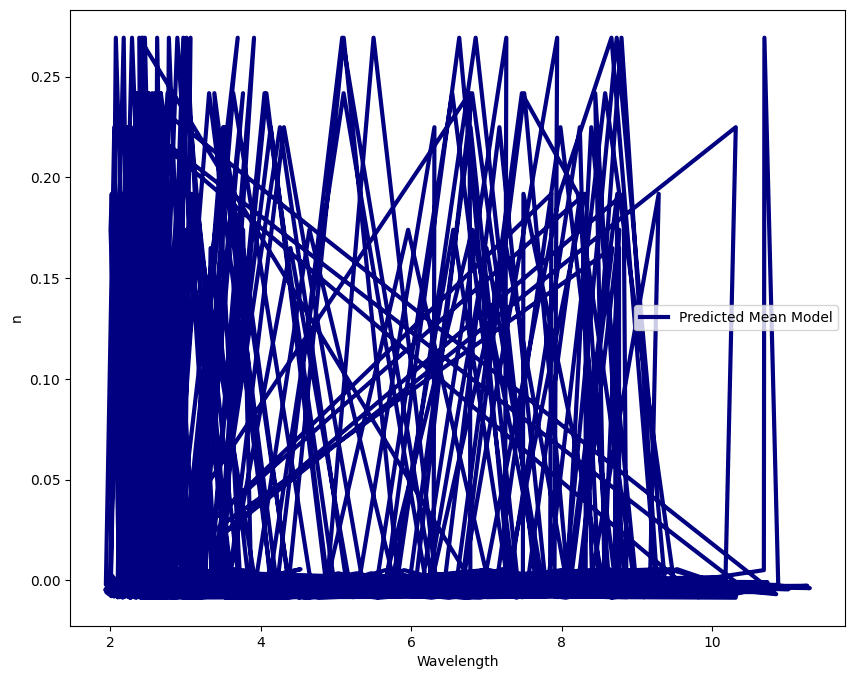

In [98]:
#plotting y0 vs x0
plt.figure(figsize=(10,8))
plt.plot(red_df,mean_n_results,color='navy',lw=3,label='Predicted Mean Model')
plt.legend()
plt.xlabel('Wavelength')    
plt.ylabel('n')
